In [1]:
import pyspark as ps
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import explode
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
spark = (ps.sql.SparkSession.builder 
        .master("local[4]").
         config("spark.driver.memory", "15g")
        .appName("recommender") 
        .getOrCreate()
        )

In [3]:
sc = spark.sparkContext

## Bundle

#### Load Bundle Data

In [4]:
bundle_rdd= sc.textFile('data/bundle_data.json')


In [5]:
bundle_rdd.count()

615

In [6]:
bundle_rdd.first()

"{'bundle_final_price': '$66.46', 'bundle_url': 'http://store.steampowered.com/bundle/450/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=SteamDB%20Bundles%20Page', 'bundle_price': '$73.86', 'bundle_name': 'Dharker Studio 2015 Complete', 'bundle_id': '450', 'items': [{'genre': 'Adventure, Indie, RPG', 'item_id': '326950', 'discounted_price': '$8.99', 'item_url': 'http://store.steampowered.com/app/326950', 'item_name': 'Sword of Asumi'}, {'genre': 'Adventure, Indie, RPG', 'item_id': '331490', 'discounted_price': '$2.99', 'item_url': 'http://store.steampowered.com/app/331490', 'item_name': 'Sword of Asumi - Soundtrack'}, {'genre': 'Adventure, Indie, RPG', 'item_id': '331491', 'discounted_price': '$1.99', 'item_url': 'http://store.steampowered.com/app/331491', 'item_name': 'Sword of Asumi - Graphic Novel'}, {'genre': 'Adventure, Indie, RPG', 'item_id': '331492', 'discounted_price': '$0.99', 'item_url': 'http://store.steampowered.com/app/331492', 'item_name': 'Sword of Asumi - Characte

#### Clean

In [7]:
bundle_rdd = bundle_rdd.map(lambda x: ast.literal_eval(x))

In [8]:
bundle_rdd.first()

{'bundle_final_price': '$66.46',
 'bundle_url': 'http://store.steampowered.com/bundle/450/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=SteamDB%20Bundles%20Page',
 'bundle_price': '$73.86',
 'bundle_name': 'Dharker Studio 2015 Complete',
 'bundle_id': '450',
 'items': [{'genre': 'Adventure, Indie, RPG',
   'item_id': '326950',
   'discounted_price': '$8.99',
   'item_url': 'http://store.steampowered.com/app/326950',
   'item_name': 'Sword of Asumi'},
  {'genre': 'Adventure, Indie, RPG',
   'item_id': '331490',
   'discounted_price': '$2.99',
   'item_url': 'http://store.steampowered.com/app/331490',
   'item_name': 'Sword of Asumi - Soundtrack'},
  {'genre': 'Adventure, Indie, RPG',
   'item_id': '331491',
   'discounted_price': '$1.99',
   'item_url': 'http://store.steampowered.com/app/331491',
   'item_name': 'Sword of Asumi - Graphic Novel'},
  {'genre': 'Adventure, Indie, RPG',
   'item_id': '331492',
   'discounted_price': '$0.99',
   'item_url': 'http://store.steampowered.c

In [15]:
bundle = bundle_rdd.toDF()

/usr/local/spark/python/pyspark/sql/session.py:398: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [16]:
bundle.columns

['bundle_discount',
 'bundle_final_price',
 'bundle_id',
 'bundle_name',
 'bundle_price',
 'bundle_url',
 'items']

In [17]:
bundle.show(5)

+---------------+------------------+---------+--------------------+------------+--------------------+--------------------+
|bundle_discount|bundle_final_price|bundle_id|         bundle_name|bundle_price|          bundle_url|               items|
+---------------+------------------+---------+--------------------+------------+--------------------+--------------------+
|            10%|            $66.46|      450|Dharker Studio 20...|      $73.86|http://store.stea...|[[genre -> Advent...|
|            22%|            $20.15|     1473|Naruto Shippuden ...|      $25.87|http://store.stea...|[[genre -> , item...|
|            22%|            $20.15|     1474|Naruto Shippuden ...|      $25.87|http://store.stea...|[[genre -> , item...|
|            40%|            $15.17|     1437|Pixel Puzzles Ult...|      $25.35|http://store.stea...|[[genre -> Casual...|
|            22%|            $20.15|     1466|Naruto Shippuden ...|      $25.87|http://store.stea...|[[genre -> , item...|
+---------------

In [18]:
bundle_pd = bundle.select("*").toPandas()

In [19]:
bundle_pd.head()

,bundle_discount,bundle_final_price,bundle_id,bundle_name,bundle_price,bundle_url,items
0,10%,$66.46,450,Dharker Studio 2015 Complete,$73.86,http://store.steampowered.com/bundle/450/?utm_...,"[{'genre': 'Adventure, Indie, RPG', 'item_name..."
1,22%,$20.15,1473,"Naruto Shippuden Uncut Season 4, Vol. 3",$25.87,http://store.steampowered.com/bundle/1473/?utm...,"[{'genre': '', 'item_name': 'Naruto Shippuden ..."
2,22%,$20.15,1474,"Naruto Shippuden Uncut Season 4, Vol. 4",$25.87,http://store.steampowered.com/bundle/1474/?utm...,"[{'genre': '', 'item_name': 'Naruto Shippuden ..."
3,40%,$15.17,1437,Pixel Puzzles Ultimate: Starter Kit,$25.35,http://store.steampowered.com/bundle/1437/?utm...,"[{'genre': 'Casual, Free to Play, Indie, Simul..."
4,22%,$20.15,1466,"Naruto Shippuden Uncut Season 4, Vol. 1",$25.87,http://store.steampowered.com/bundle/1466/?utm...,"[{'genre': '', 'item_name': 'Naruto Shippuden ..."


In [20]:
dfs = []
for i in range(bundle_pd.shape[0]):
    df = pd.DataFrame(bundle_pd['items'][i])
    df['bundle_id']= bundle_pd['bundle_id'][i]
    dfs.append(df)


In [21]:
bundle_pd = pd.concat(dfs)

In [22]:
bundle_pd.reset_index(inplace= True)


In [23]:
bundle_pd.columns

Index(['index', 'genre', 'item_name', 'item_id', 'item_url',
       'discounted_price', 'bundle_id'],
      dtype='object')

In [24]:
bundle_pd.drop(['index'],axis = 1, inplace=True)

In [25]:
bundle_pd

,genre,item_name,item_id,item_url,discounted_price,bundle_id
0,"Adventure, Indie, RPG",Sword of Asumi,326950,http://store.steampowered.com/app/326950,$8.99,450
1,"Adventure, Indie, RPG",Sword of Asumi - Soundtrack,331490,http://store.steampowered.com/app/331490,$2.99,450
2,"Adventure, Indie, RPG",Sword of Asumi - Graphic Novel,331491,http://store.steampowered.com/app/331491,$1.99,450
3,"Adventure, Indie, RPG",Sword of Asumi - Character Creator,331492,http://store.steampowered.com/app/331492,$0.99,450
4,"Adventure, Casual, Indie",Divine Slice of Life,348540,http://store.steampowered.com/app/348540,$12.99,450
...,...,...,...,...,...,...
3520,"Action, Adventure, Casual, Indie",Dyna Bomb,467220,http://store.steampowered.com/app/467220,$4.99,588
3521,"Action, Adventure, Casual, Indie",Dyna Bomb - Soundtrack OST,485090,http://store.steampowered.com/app/485090,$1.99,588
3522,"Action, Adventure, Indie",Ninjahtic,385230,http://store.steampowered.com/app/385230,$1.99,594
3523,"Action, Adventure, Indie",Ninjahtic Mind Tricks,387880,http://store.steampowered.com/app/387880,$1.99,594


#### Number of Bundles

In [26]:
bundle_pd['bundle_id'].nunique()

615

#### Number of Different Games

In [27]:
bundle_pd['item_id'].nunique()

2798

#### Number of Games from Bundle in User Reviews

In [28]:
bundle_pd.item_id.isin(user_reviews_pd.item_id).sum()

NameError: name 'user_reviews_pd' is not defined

## Games

#### Load Games Data

In [29]:
games_rdd = sc.textFile('data/steam_games (3).json')

In [30]:
games_rdd.count()

32135

#### Clean

In [31]:
games_rdd= games_rdd.map(lambda x: ast.literal_eval(x))

In [32]:
games = games_rdd.toDF()

/usr/local/spark/python/pyspark/sql/session.py:398: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [33]:
games.show(1)

+-------------------+---------+--------------+------------+--------------------+------+-----+---------+------------+--------------------+---------------+--------------------+-------------------+--------------------+
|           app_name|developer|discount_price|early_access|              genres|    id|price|publisher|release_date|         reviews_url|          specs|                tags|              title|                 url|
+-------------------+---------+--------------+------------+--------------------+------+-----+---------+------------+--------------------+---------------+--------------------+-------------------+--------------------+
|Lost Summoner Kitty|Kotoshiro|          4.49|       false|[Action, Casual, ...|761140| 4.99|Kotoshiro|  2018-01-04|http://steamcommu...|[Single-player]|[Strategy, Action...|Lost Summoner Kitty|http://store.stea...|
+-------------------+---------+--------------+------------+--------------------+------+-----+---------+------------+--------------------

In [33]:
games.agg(countDistinct(col("id")).alias("count")).show()

NameError: name 'countDistinct' is not defined

## User Reviews

In [34]:
user_reviews_rdd= sc.textFile('data/australian_user_reviews (2).json')

In [35]:
user_reviews_rdd.count()

25799

In [36]:
user_reviews_rdd.first()

'{\'user_id\': \'76561197970982479\', \'user_url\': \'http://steamcommunity.com/profiles/76561197970982479\', \'reviews\': [{\'funny\': \'\', \'posted\': \'Posted November 5, 2011.\', \'last_edited\': \'\', \'item_id\': \'1250\', \'helpful\': \'No ratings yet\', \'recommend\': True, \'review\': \'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.\'}, {\'funny\': \'\', \'posted\': \'Posted July 15, 2011.\', \'last_edited\': \'\', \'item_id\': \'22200\', \'helpful\': \'No ratings yet\', \'recommend\': True, \'review\': "It\'s unique and worth a playthrough."}, {\'funny\': \'\', \'posted\': \'Posted April 21, 2011.\', \'last_edited\': \'\', \'item_id\': \'43110\', \'helpful\': \'No ratings yet\', \'recommend\': True, \'review\': \'Great atmosphere. The gunplay can be a bit chunky at times but 

In [37]:
user_reviews_rdd= user_reviews_rdd.map(lambda x: ast.literal_eval(x))

In [38]:
user_reviews_rdd.first()

{'user_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'reviews': [{'funny': '',
   'posted': 'Posted November 5, 2011.',
   'last_edited': '',
   'item_id': '1250',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
  {'funny': '',
   'posted': 'Posted July 15, 2011.',
   'last_edited': '',
   'item_id': '22200',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': "It's unique and worth a playthrough."},
  {'funny': '',
   'posted': 'Posted April 21, 2011.',
   'last_edited': '',
   'item_id': '43110',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this 

In [41]:
user_reviews = user_reviews_rdd.toDF()

In [42]:
user_reviews.show(1)

+--------------------+-----------------+--------------------+
|             reviews|          user_id|            user_url|
+--------------------+-----------------+--------------------+
|[[last_edited -> ...|76561197970982479|http://steamcommu...|
+--------------------+-----------------+--------------------+
only showing top 1 row



In [14]:
user_reviews.agg(countDistinct(col("user_id")).alias("count")).show()

+-----+
|count|
+-----+
|25485|
+-----+



In [43]:
user_reviews_pd = user_reviews.select("*").toPandas()

In [44]:
user_reviews_pd.head()

,reviews,user_id,user_url
0,"[{'last_edited': '', 'item_id': '1250', 'revie...",76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,"[{'last_edited': '', 'item_id': '251610', 'rev...",js41637,http://steamcommunity.com/id/js41637
2,"[{'last_edited': '', 'item_id': '248820', 'rev...",evcentric,http://steamcommunity.com/id/evcentric
3,"[{'last_edited': '', 'item_id': '250320', 'rev...",doctr,http://steamcommunity.com/id/doctr
4,"[{'last_edited': '', 'item_id': '211420', 'rev...",maplemage,http://steamcommunity.com/id/maplemage


In [45]:
user_reviews_pd.shape

(25799, 3)

In [46]:
user_reviews_pd['user_id'].nunique()

25485

In [47]:
user_reviews_pd[user_reviews_pd['user_id'].duplicated()]

,reviews,user_id,user_url
456,"[{'last_edited': '', 'item_id': '346110', 'rev...",bokkkbokkk,http://steamcommunity.com/id/bokkkbokkk
1182,"[{'last_edited': '', 'item_id': '218620', 'rev...",ImSeriouss,http://steamcommunity.com/id/ImSeriouss
1456,"[{'last_edited': '', 'item_id': '570', 'review...",76561198062039159,http://steamcommunity.com/profiles/76561198062...
1477,"[{'last_edited': '', 'item_id': '570', 'review...",76561198045009232,http://steamcommunity.com/profiles/76561198045...
1746,"[{'last_edited': '', 'item_id': '22320', 'revi...",nitr0ticwolf,http://steamcommunity.com/id/nitr0ticwolf
...,...,...,...
17819,"[{'last_edited': '', 'item_id': '368230', 'rev...",76561198076474887,http://steamcommunity.com/profiles/76561198076...
17916,"[{'last_edited': '', 'item_id': '250320', 'rev...",yolofaceguy,http://steamcommunity.com/id/yolofaceguy
18028,"[{'last_edited': '', 'item_id': '242570', 'rev...",76561198075591109,http://steamcommunity.com/profiles/76561198075...
18234,"[{'last_edited': '', 'item_id': '422400', 'rev...",76561198092022514,http://steamcommunity.com/profiles/76561198092...


In [48]:
user_reviews_pd.drop_duplicates(subset ="user_id", 
                     keep = 'first', inplace = True) 
  

In [49]:
user_reviews_pd.reset_index(inplace =True)

In [50]:
user_reviews_pd.columns

Index(['index', 'reviews', 'user_id', 'user_url'], dtype='object')

In [51]:
user_reviews_pd.drop(['index'],axis = 1,inplace=True)

In [52]:
user_reviews_pd.head()

,reviews,user_id,user_url
0,"[{'last_edited': '', 'item_id': '1250', 'revie...",76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,"[{'last_edited': '', 'item_id': '251610', 'rev...",js41637,http://steamcommunity.com/id/js41637
2,"[{'last_edited': '', 'item_id': '248820', 'rev...",evcentric,http://steamcommunity.com/id/evcentric
3,"[{'last_edited': '', 'item_id': '250320', 'rev...",doctr,http://steamcommunity.com/id/doctr
4,"[{'last_edited': '', 'item_id': '211420', 'rev...",maplemage,http://steamcommunity.com/id/maplemage


In [53]:
user_reviews_pd.shape

(25485, 3)

In [54]:
dfs = []
for i in range(user_reviews_pd.shape[0]):
    df = pd.DataFrame(user_reviews_pd['reviews'][i])
    df['user_id']= user_reviews_pd['user_id'][i]
    dfs.append(df)


In [55]:
user_reviews_pd = pd.concat(dfs)

In [56]:
user_reviews_pd.head()

,last_edited,item_id,review,recommend,helpful,funny,posted,user_id
0,,1250,Simple yet with great replayability. In my opi...,true,No ratings yet,,"Posted November 5, 2011.",76561197970982479
1,,22200,It's unique and worth a playthrough.,true,No ratings yet,,"Posted July 15, 2011.",76561197970982479
2,,43110,Great atmosphere. The gunplay can be a bit chu...,true,No ratings yet,,"Posted April 21, 2011.",76561197970982479
0,,251610,I know what you think when you see this title ...,true,15 of 20 people (75%) found this review helpful,,"Posted June 24, 2014.",js41637
1,,227300,For a simple (it's actually not all that simpl...,true,0 of 1 people (0%) found this review helpful,,"Posted September 8, 2013.",js41637


In [57]:
user_reviews_pd.reset_index(inplace = True)

In [58]:
user_reviews_pd.drop(['index'], axis = 1,inplace = True)

In [59]:
user_reviews_pd.head()

,last_edited,item_id,review,recommend,helpful,funny,posted,user_id
0,,1250,Simple yet with great replayability. In my opi...,true,No ratings yet,,"Posted November 5, 2011.",76561197970982479
1,,22200,It's unique and worth a playthrough.,true,No ratings yet,,"Posted July 15, 2011.",76561197970982479
2,,43110,Great atmosphere. The gunplay can be a bit chu...,true,No ratings yet,,"Posted April 21, 2011.",76561197970982479
3,,251610,I know what you think when you see this title ...,true,15 of 20 people (75%) found this review helpful,,"Posted June 24, 2014.",js41637
4,,227300,For a simple (it's actually not all that simpl...,true,0 of 1 people (0%) found this review helpful,,"Posted September 8, 2013.",js41637


In [60]:
user_reviews_pd.shape

(58430, 8)

In [61]:
user_reviews_pd['user_id'].nunique()

25457

In [62]:
user_reviews_pd['item_id'].nunique()

3682

In [63]:
num_ratings = 58430
num_users = 25457
num_games= 3682
density = num_ratings/(num_users*num_games)
density

0.0006233685384885104

In [64]:
user_counts= user_reviews_pd.groupby('user_id')['item_id'].count().values
game_counts = user_reviews_pd.groupby('item_id')['user_id'].count().values


In [65]:
user_counts.max()

10

In [66]:
user_counts.min()

1

In [67]:
game_counts.max()

3708

In [68]:
game_counts.min()

1

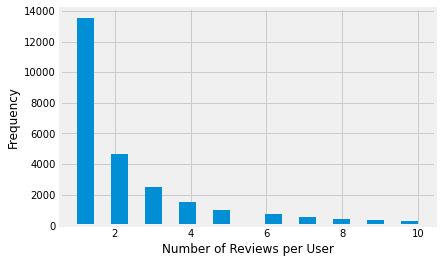

In [69]:
fig, ax = plt.subplots()
ax.hist(user_counts, bins=20)
ax.set_xlabel('Number of Reviews per User')
ax.set_ylabel('Frequency');

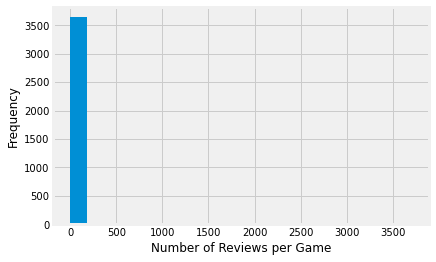

In [70]:
fig, ax = plt.subplots()
ax.hist(game_counts, bins=20)
ax.set_xlabel('Number of Reviews per Game')
ax.set_ylabel('Frequency');

## User Items

#### Load Data into RDD

In [4]:
users_items_rdd = sc.textFile('data/australian_users_items (2).json')

In [5]:
users_items_rdd.count()

88310

In [6]:
users_items_rdd.first()

'{\'user_id\': \'76561197970982479\', \'items_count\': 277, \'steam_id\': \'76561197970982479\', \'user_url\': \'http://steamcommunity.com/profiles/76561197970982479\', \'items\': [{\'item_id\': \'10\', \'item_name\': \'Counter-Strike\', \'playtime_forever\': 6, \'playtime_2weeks\': 0}, {\'item_id\': \'20\', \'item_name\': \'Team Fortress Classic\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'30\', \'item_name\': \'Day of Defeat\', \'playtime_forever\': 7, \'playtime_2weeks\': 0}, {\'item_id\': \'40\', \'item_name\': \'Deathmatch Classic\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'50\', \'item_name\': \'Half-Life: Opposing Force\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'60\', \'item_name\': \'Ricochet\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'70\', \'item_name\': \'Half-Life\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'130\', \'item_name\': \'Half-Life: Blue Shif

#### Clean

In [7]:
users_items_rdd= users_items_rdd.map(lambda x: ast.literal_eval(x))

In [8]:
users_items_rdd.first()

{'user_id': '76561197970982479',
 'items_count': 277,
 'steam_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'items': [{'item_id': '10',
   'item_name': 'Counter-Strike',
   'playtime_forever': 6,
   'playtime_2weeks': 0},
  {'item_id': '20',
   'item_name': 'Team Fortress Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '30',
   'item_name': 'Day of Defeat',
   'playtime_forever': 7,
   'playtime_2weeks': 0},
  {'item_id': '40',
   'item_name': 'Deathmatch Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '50',
   'item_name': 'Half-Life: Opposing Force',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '60',
   'item_name': 'Ricochet',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '70',
   'item_name': 'Half-Life',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '130',
   'item_name': 'Half-Life: Blue Shift',
   'playtime_forever

#### Convert to Dataframe

In [9]:
users_items = users_items_rdd.toDF()

/usr/local/spark/python/pyspark/sql/session.py:398: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [10]:
users_items.show(1)

+--------------------+-----------+-----------------+-----------------+--------------------+
|               items|items_count|         steam_id|          user_id|            user_url|
+--------------------+-----------+-----------------+-----------------+--------------------+
|[[item_name -> Co...|        277|76561197970982479|76561197970982479|http://steamcommu...|
+--------------------+-----------+-----------------+-----------------+--------------------+
only showing top 1 row



In [13]:
users_items.agg(countDistinct(col("user_id")).alias("count")).show()

+-----+
|count|
+-----+
|87626|
+-----+



In [11]:
columns_to_drop = ['steam_id', 'user_url']
users_items = users_items.drop(*columns_to_drop)

In [12]:
users_items.show(1)

+--------------------+-----------+-----------------+
|               items|items_count|          user_id|
+--------------------+-----------+-----------------+
|[[item_name -> Co...|        277|76561197970982479|
+--------------------+-----------+-----------------+
only showing top 1 row



#### Drop Duplicate Users

In [13]:
users_items = users_items.dropDuplicates(['user_id'])

In [14]:
users_items.count()

87626

#### Explode Items Column to Extract Playtime of Games

In [15]:
play_history = users_items.select('user_id',explode("items").alias("i"))
play_history = play_history.selectExpr('user_id','i.item_id','i.item_name', 'i.playtime_forever')


In [20]:
play_history.show(1)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:41383)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:41383)

In [48]:
flatten_items.count()

5153209

In [56]:
users_items_pd = flatten_items.select('*').toPandas()

SyntaxError: invalid syntax (<ipython-input-56-953b3444bf56>, line 1)

In [108]:
flatten_items.dtypes

[('item_id', 'string'),
 ('item_name', 'string'),
 ('playtime_forever', 'string')]

In [144]:
flatten_items.agg(countDistinct(col("item_id")).alias("count")).show()

+-----+
|count|
+-----+
|10978|
+-----+



In [ ]:
flatten_items.agg(countDistinct(col("item_name")).alias("count")).show()

## Reviews

In [74]:
reviews_rdd = sc.textFile('data/steam_reviews.json')

In [75]:
reviews_rdd.count()

7793069

In [76]:
reviews_rdd.first()

"{u'username': u'Chaos Syren', u'hours': 0.1, u'products': 41, u'product_id': u'725280', u'page_order': 0, u'date': u'2017-12-17', u'text': u'This would not be acceptable as an entertainment even back in the day when these graphics were all there was to be had. No effort has been made to bring the player into any story or even entertain.', u'early_access': False, u'page': 1}"

In [77]:
reviews_rdd= reviews_rdd.map(lambda x: ast.literal_eval(x))

In [78]:
reviews_rdd.take(10)

[{'username': 'Chaos Syren',
  'hours': 0.1,
  'products': 41,
  'product_id': '725280',
  'page_order': 0,
  'date': '2017-12-17',
  'text': 'This would not be acceptable as an entertainment even back in the day when these graphics were all there was to be had. No effort has been made to bring the player into any story or even entertain.',
  'early_access': False,
  'page': 1},
 {'username': '₮ʜᴇ Wᴀʀᴛᴏɴ',
  'hours': 51.1,
  'products': 769,
  'product_id': '328100',
  'page_order': 0,
  'date': '2017-12-27',
  'text': 'looks like a facebook game',
  'early_access': False,
  'page': 1},
 {'username': 'hello?<',
  'text': 'Better than Minecraft',
  'hours': 14.6,
  'date': '2017-10-16',
  'early_access': False,
  'found_funny': 2,
  'product_id': '328100',
  'page_order': 1,
  'compensation': 'Product received for free',
  'products': 2,
  'page': 1},
 {'username': 'Cyderine916',
  'hours': 5.0,
  'products': 64,
  'product_id': '35140',
  'page_order': 0,
  'date': '2018-01-04',
  'tex

In [79]:
reviews = reviews_rdd.toDF()

In [80]:
reviews.show(5)

+----------+------------+-----+----+----------+----------+--------+--------------------+--------------+
|      date|early_access|hours|page|page_order|product_id|products|                text|      username|
+----------+------------+-----+----+----------+----------+--------+--------------------+--------------+
|2017-12-17|       false|  0.1|   1|         0|    725280|      41|This would not be...|   Chaos Syren|
|2017-12-27|       false| 51.1|   1|         0|    328100|     769|looks like a face...|    ₮ʜᴇ Wᴀʀᴛᴏɴ|
|2017-10-16|       false| 14.6|   1|         1|    328100|       2|Better than Minec...|       hello?<|
|2018-01-04|       false|  5.0|   1|         0|     35140|      64|I love and idoliz...|   Cyderine916|
|2018-01-04|       false| 16.6|   1|         1|     35140|     577|Still worth playi...|DarklyThinking|
+----------+------------+-----+----+----------+----------+--------+--------------------+--------------+
only showing top 5 rows



In [81]:
reviews.agg(countDistinct(col("product_id")).alias("count")).show()

+-----+
|count|
+-----+
|15474|
+-----+



## Intersection of Users Items and User Reviews

In [149]:
users_items_user_id.user_id.isin(user_reviews_pd.user_id).sum()

25770

In [151]:
user_reviews_pd['user_id'].nunique()

25458

In [153]:
duplicates = user_reviews_pd['user_id'].duplicated()